# General Introduction

This section provides you with a general introduction to hands-on sessions.

The idea is that you will work on your own, following the instructions reported in the notebooks. The instructors will be available to answer questions, discuss issues and problems individually and/or with the rest of the class. At the beginning of each notebook, there's a small summary of its content. You should be able to complete the whole notebook in 2 hours.

Throughout the notebooks, whenever you find a blue box like this one:

<div class="alert alert-block alert-info">
<b>Question:</b> What should you do when you find a blue box?
</div>

It means that there's a question for you to think about. Instead, a yellow box like this one:

<div class="alert alert-block alert-warning">
<b>Task:</b> Complete the following cell by adding X lines of code.
</div>

It means that there's some code for you to write. Finally, only for this notebook tou can also find a green box like this one:

<div class="alert alert-block alert-success">
<b>Code block:</b> Check the following code in the codebase.
</div>

It means that you have to check the codebase to understand what is happing in the functions.

# Hands-on #4: DNN Compilation and Deployment

In this notebook, you will:
1. Take the onnx exported quantized model from Hands-on #3, import it in the MATCH compiler, visualize it, and compare it with the onnx graph.
2. Transform the graph with MATCH Compiler and generate the final C code.
3. Test the PULP_SDK and run a hello-world on the virtual simulator.
4. Execute an inference on the virtual simulator, GVSoC.

# Setup

1. Define paths for match_output, network, and dataset.  
2. Specify the paths of the PULP_SDK to be used.  
3. Specify the paths of MATCH and TVM tools.

In [1]:
import pathlib
import os
import sys

#compilation tools
# set the paths to correctly set up match
username = os.environ.get('USER')
oenne_path = f'/home/alessio/Desktop/oenne/' 

MATCH_OUTPUT = pathlib.Path(f'/home/alessio/Desktop/pulpatch/pulpatch/match_output')
NETWORK_PATH = oenne_path + "checkpoints/03/GraphModule.onnx"
DATASET_DIR = pathlib.Path(oenne_path + "dataset/")
os.environ["PULP_SDK"]=f'/home/alessio/pulp-sdk/'
os.environ["PULP_RISCV_GCC_TOOLCHAIN"]=f'/home/alessio/v1.0.16-pulp-riscv-gcc-ubuntu-18/'

os.environ["MATCH_PATH"]=f'/home/alessio/Desktop/match'
os.environ["TVM_HOME"]=os.environ["MATCH_PATH"]+"/match-tvm"
sys.path.insert(0,f"{os.environ.get('TVM_HOME')}/python")
sys.path.insert(0,f"{os.environ.get('MATCH_PATH')}/zigzag")
print(os.environ.get("TVM_HOME"))

/home/alessio/Desktop/match/match-tvm


First, we have to load Python packages for the different tasks:
1. **torch** and **matplotlib**: needed to load data for the final application and visualize them;
2. our compilation tools: **match** and **pulpatch**. To load MATCH, you set up above the correct paths for MATCH, TVM, and ZigZag;
3. library for UART communication for the final application: **serial**;
4. library for ONNX import and display: **onnx** and **netron**;
5. ipython widgets and HTML packages: **ipywidgets** and **HTML**;
6. **utils.deployment**: custom functions for PULP deployment;

In [2]:
import numpy as np
import json

import torch
import pytorch_benchmarks.image_classification as icl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import match
import pulpatch
# needed to support UART Communication
import serial

#import onnx graph and display it
import onnx
import netron

#import widgets and display libraries
import ipywidgets as widgets
from IPython.display import HTML

#deployment functions
import utils.deployment as utils

# Step 1: Import the graph in MATCH

During the first hands-on step, we'll take our generated network from Hands-on #3.  
This network has been quantized and exported with the Plinio tool using the MPS algorithm. Note that the exported is specifically thought to create an Onnx in a format that could be read from the compilation tool, MATCH.  
First, we import the network. Then, in the first step, MATCH transforms the Onnx in the Relay Graph that uses Relay-IR to identify each network operator..

<div class="alert alert-block alert-info">
<b>Task:</b> Check the format of the <b>get_relay_network</b> function in match/match/run.py. Note that the params_filename should be empty when using the onnx format.
</div>



In [3]:
# look at the relay network by using the get_relay_network. 
relay_mod, _ = match.get_relay_network(filename=NETWORK_PATH)

Compare the ONNX graph and the RELAY graph.

<div class="alert alert-block alert-info">
<b>Question:</b> Do you see any difference between the graphs? 
</div>

In [4]:
# Load your ONNX model
onnx_model = onnx.load(NETWORK_PATH)

# Save the ONNX model locally if it's not already saved
onnx.save(onnx_model, NETWORK_PATH)

# Serve the model using Netron
netron.start(NETWORK_PATH, browse=False)
netron_url = "http://localhost:5997" # ADAPT IF NECESSARY

# Assuming relay_mod is already defined in your environment
relay_mod_str = str(relay_mod)  # Convert relay_mod to a string representation

# Create the HTML content
html_content = f'''
<div style="display: flex;">
    <div style="flex: 1; padding: 10px;">
        <h3>ONNX Model Graph</h3>
        <iframe src="{netron_url}" width="600" height="5000"></iframe>
    </div>
    <div style="flex: 1; padding: 10px;">
        <h3>Relay Module</h3>
        <pre>{relay_mod_str}</pre>
    </div>
</div>
'''

# Display the HTML content
display(HTML(html_content))

Serving '/home/alessio/Desktop/oenne/checkpoints/03/GraphModule.onnx' at http://localhost:8080


# Step 2: Partition the graph and match with HW primitives

In the Step 2, we will see how the input network is transformed in MATCH, using HW specific features and exploiting HW specific kernels and models.  
The first thing to define is the HW target: in our case, we will use the PULP target. PULP (Parallel Ultra Low Power) is a family of SoCs characterized by multiple RISC-V Cores. Below, we describe the GAP9 Evaluation board, a commercial embodiment of this paradigm.

<br>
<center><img src="./assets/GAP9_blockdiagram.png" alt="setup" class="bg-primary" width="800px"></center>
<center> Fig.1: GAP9 block diagram. </center>
<be>

The GAP9 SoC has a main core (*Fabric Controller*) to manage I/O and 9 cores (*Compute Cluster*) for workload accelerator. All 10 cores are based on the RISC-V Instruction Set Architecture extended with custom instructions automatically used by the GAP toolchain. The Cluster is perfectly adapted to handling combinations of neural network and digital signal processing tasks delivering programmable compute power at extreme energy efficiency. In terms of memory, GAP9 features a 2-level internal hierarchy, with a larger (2 MB) but slower L2 memory, and a faster but smaller 128 kB L1 memory, accessible from Cluster cores with single-cycle latency. This memory is the one to be used to maximize the efficiency of your neural network.  
GAP9 also features the NE16 accelerator for CNNs that however is only specific of this architecture and it will therefore not be used for our generic pulp target.


In [5]:
#define PULP OPEN HW Target inside match
target=match.target.PulpOpen()


In the following, we will parse the Onnx input network with the function *match.match()* to generate the compiled application.  
Despite being a single call to a function, it is important to understand what is going on inside match.

<div class="alert alert-block alert-success">
<b>Code block:</b> In order to understand, check the following code in the codebase of MATCH at MATCH_PATH.<br>
    1. <b>match</b> function in match/match/run.py;  <br>
    2. <b>driver</b>, tvm_compile function in match/match/driver/driver.py;<br>
    3. <b>tvmc_compile_and_unpack</b> match/match/relay/utils/utils.py;<br>
</div>

Some comments on these functions:  
1. **match** has a series of default operations for TVM and the driver function needed to create the output C code; the *match* function generate the layer functions which will be then called inside the main. You can check them in *MATCH_OUTPUT/codegen/host/src/*
2. **driver** function. This is the calling function of the compilation process. Inside the function, you specify the input, the output directory and the target platform for which you want to generate the code. **Note that this is crucial, given that MANY optimization steps depends on the target HW**; arguments 
    - *relay_mod*: relay graph obtained in *get_relay_from* function;
    - *relay_params*: needed only if not giving an onnx as an input;
    - *target*: platform for which you want to generate the code;
    - *output_path*: directory where the code is saved;
3. **tvmc_compile_and_unpack** function: it calls the final tvm compilation
4. the **compile_model** function is the TVM-called function that does the job. In particular, you can check the functions that do two specific passes you saw in the lecture:
    -  *apply_graph_transforms*
    -  *partition_function*
   
<div class="alert alert-block alert-success">
<b>Code block:</b> Check carefully <b>compile_model</b> at MATCH_PATH/match-tvm/python/tvm/driver/tvmc/compiler.py
</div>

Inside the function, you will see that most of the variable used depends on the HW target.

#### match.match function
Reading the *compile_model* function, you may have explored the partitioning function.  
To create the final code for a target HW, MATCH performs the following operations:  
1. *pattern matching*: it checks the patterns in the relay graph and compares them with a series of patterns saved for each HW target. MATCH saves for each new HW target a list of patterns that have to be compared with the relay graph; Check the patterns for PULP at **MATCH_PATH/match/target/pulpopen/cluster/partitioning_patterns.py**
2. *graph_transformation*: after matching the pattern, the relay graph is modified, and the corresponding patterns are mapped to the target HW;
3. *BYOC offloading*: for each block, the mapping is generated with ZigZag. Note that in the output below, you will read an estimated latency and energy: these estimations are used by ZigZag to split and tile the layer loops optimally.


The output in the next cell will show the mapping of each node.

## BYOC and ZigZag
As you saw during the lesson, MATCH uses the ZigZag tool as BYOC add-on to TVM: https://github.com/KULeuven-MICAS/zigzag  
ZigZag is a tool from KU Leuven University that gives us the possibility to perform two main operations:
1. *Spatial Tiling*: distribute operations among different processing elements (PE) in our architecture;
2. *Temporal Tiling*: distribute operations over time;

Let's have a simple example: consider a systolic array with dimension 4x4, which parallelizes on output channel (K) and one of the output dimensions (OX)
<br>
<center><img src="./assets/Systolic.png" alt="setup" class="bg-primary" width="600px"></center>
<center> Fig.2: Systolic array of dimension 4x4. </center>
<be>

In this case, the spatial tiling will be K=4, OX=4. In other words, it means that 4 output channels and 4 output positions will be processed in parallel by our HW.
On top of the spatial tiling, all the other loops will be temporally tiled: at every new time step, a new tile will be executed.
Let's consider a simple convolutional layer with input 16x16 (IX = IY = OX = OY), C=8, K=16, and Fx=Fy=3:

<br>
<center><img src="./assets/tiling.png" alt="setup" class="bg-primary" width="600px"></center>
<center> Fig.3: Tiling split of ZigZag. </center>
<be>

As the figure shows, the K and OX loops are split to be temporally and spatially tiled.  
Note that beside the tiling, ZigZag also performs loop re-ordering and memory allocation. If you are interested to all the details about ZigZag, you can read the paper from KU Lueven:  
https://arxiv.org/abs/2007.11360

Now, moving to our PULP architecture, we do not have a "fixed" systolic array, but 8 general purpose cores. We use the PULP-NN library (https://github.com/pulp-platform/pulp-nn) as convolutional backend. This library does not have spatial tiling constraints but is optimized to execute with OY = 8, OX = 2, K = 4. Therefore, while we never force a specific spatial tiling, we always try to be near these values as possible.

### Pattern Matching & Partitioned Graph

Final note before looking at the actual output of the function. MATCH prints the expected latency and energy for the final configuration of every pattern matched (*do you remember gap9.cluster.conv2d_bnorm_requant from the partitioning_patterns.py file?*). Note that to choose the final tiling, loop order, and loop partitioning, ZigZag uses internal HW models that compute energy and latency based on each different configuration. After a model-based search, the final hyperparameters are chosen. The ones that you see as output of the function, are only the best latency and energy values found for each layer.

In res.mod variable, you can also read each specific node processed by MATCH of your specific network.

In the first part, you can see the main structure with the call to the different individual layers of the network.
As you may notice, most of the layers are identified with the acronym tvmgen to specify they have been processed by the BYOC section of MATCH.

In the second part, you can look at which individual functions are called inside each *pattern* recognized by the BYOC.

In [6]:
res=match.match(filename=NETWORK_PATH,target=target,output_path=MATCH_OUTPUT)
print(res.mod)

2024-06-25 17:06:06,175 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2024-06-25 17:06:06,177 - run +29 - INFO - Processing layer 0...
2024-06-25 17:06:06,178 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('OY', 8), 'D2': ('OX', 2), 'D3': ('K', 4)}.
2024-06-25 17:06:06,180 - run +74 - INFO - Running temporal mapping search engine...
  0%|                                     | 420/415800 [00:02<46:24, 149.16it/s]
2024-06-25 17:06:09,005 - run +44 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 2.774e+07 and latency 4.994e+04 to tmp/match-layer_LayerNode_1_complete.json
2024-06-25 17:06:09,007 - run +98 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 2.774e+07 and latency 4.994e+04 to tmp/match-layer_LayerNode_1_simple.json
2024-06-25 17:06:09,011 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.
2024-06-25 17:06:09,021 - parse_wo


Node is supported by pulpopen.cluster.conv2d_bnorm_requant with expected latency 49944.0 and expected energy 27742134.72



  0%|                                      | 120/60480 [00:00<04:29, 223.94it/s]
2024-06-25 17:06:09,564 - run +44 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 7.047e+07 and latency 1.081e+05 to tmp/match-layer_LayerNode_1_complete.json
2024-06-25 17:06:09,566 - run +98 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 7.047e+07 and latency 1.081e+05 to tmp/match-layer_LayerNode_1_simple.json
2024-06-25 17:06:09,571 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.
2024-06-25 17:06:09,588 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2024-06-25 17:06:09,589 - run +29 - INFO - Processing layer 0...
2024-06-25 17:06:09,589 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('OY', 8), 'D2': ('OX', 2), 'D3': ('K', 3)}.
2024-06-25 17:06:09,590 - run +74 - INFO - Running temporal mapping search engine...



Node is supported by pulpopen.cluster.conv2d_bnorm_requant with expected latency 108138.0 and expected energy 70470076.8



  1%|▎                                         | 3/360 [00:00<00:01, 251.67it/s]
2024-06-25 17:06:09,608 - run +44 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 6.311e+07 and latency 9.754e+04 to tmp/match-layer_LayerNode_1_complete.json
2024-06-25 17:06:09,609 - run +98 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 6.311e+07 and latency 9.754e+04 to tmp/match-layer_LayerNode_1_simple.json
2024-06-25 17:06:09,613 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.
2024-06-25 17:06:09,627 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2024-06-25 17:06:09,628 - run +29 - INFO - Processing layer 0...
2024-06-25 17:06:09,630 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('K', 3), 'D2': ('OX', 4), 'D3': ('OY', 4)}.
2024-06-25 17:06:09,631 - run +74 - INFO - Running temporal mapping search engine...



Node is supported by pulpopen.cluster.conv2d_bnorm_requant with expected latency 97535.0 and expected energy 63110198.4



 17%|███████▎                                    | 1/6 [00:00<00:00, 115.24it/s]
2024-06-25 17:06:09,653 - run +44 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 7.764e+05 and latency 3.756e+03 to tmp/match-layer_LayerNode_1_complete.json
2024-06-25 17:06:09,656 - run +98 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 7.764e+05 and latency 3.756e+03 to tmp/match-layer_LayerNode_1_simple.json
2024-06-25 17:06:09,664 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.
2024-06-25 17:06:09,694 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2024-06-25 17:06:09,695 - run +29 - INFO - Processing layer 0...
2024-06-25 17:06:09,696 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('OY', 4), 'D2': ('OX', 4), 'D3': ('K', 4)}.
2024-06-25 17:06:09,697 - run +74 - INFO - Running temporal mapping search engine...



Node is supported by pulpopen.cluster.conv2d_bnorm_requant with expected latency 3756.0 and expected energy 776398.32



 50%|██████████████████████                      | 1/2 [00:00<00:00, 276.54it/s]
2024-06-25 17:06:09,706 - run +44 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 7.348e+06 and latency 2.734e+04 to tmp/match-layer_LayerNode_1_complete.json
2024-06-25 17:06:09,708 - run +98 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 7.348e+06 and latency 2.734e+04 to tmp/match-layer_LayerNode_1_simple.json
2024-06-25 17:06:09,711 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.
2024-06-25 17:06:09,743 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2024-06-25 17:06:09,745 - run +29 - INFO - Processing layer 0...
2024-06-25 17:06:09,746 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('K', 4), 'D2': ('OX', 4), 'D3': ('OY', 4)}.
2024-06-25 17:06:09,749 - run +74 - INFO - Running temporal mapping search engine...



Node is supported by pulpopen.cluster.conv2d_bnorm_requant with expected latency 27337.0 and expected energy 7348253.52



 17%|███████▌                                     | 1/6 [00:00<00:00, 92.89it/s]
2024-06-25 17:06:09,780 - run +44 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 1.679e+06 and latency 7.135e+03 to tmp/match-layer_LayerNode_1_complete.json
2024-06-25 17:06:09,783 - run +98 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 1.679e+06 and latency 7.135e+03 to tmp/match-layer_LayerNode_1_simple.json
2024-06-25 17:06:09,791 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.



Node is supported by pulpopen.cluster.conv2d_bnorm_requant with expected latency 7135.0 and expected energy 1679364.24



2024-06-25 17:06:09,838 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2024-06-25 17:06:09,839 - run +29 - INFO - Processing layer 0...
2024-06-25 17:06:09,842 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('OY', 4), 'D2': ('OX', 4), 'D3': ('K', 1)}.
2024-06-25 17:06:09,844 - run +74 - INFO - Running temporal mapping search engine...
 50%|██████████████████████                      | 1/2 [00:00<00:00, 304.22it/s]
2024-06-25 17:06:09,854 - run +44 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 3.951e+07 and latency 3.178e+05 to tmp/match-layer_LayerNode_1_complete.json
2024-06-25 17:06:09,857 - run +98 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 3.951e+07 and latency 3.178e+05 to tmp/match-layer_LayerNode_1_simple.json
2024-06-25 17:06:09,862 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.



Node is supported by pulpopen.cluster.conv2d_bnorm_requant with expected latency 317754.0 and expected energy 39508944.72



2024-06-25 17:06:09,958 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2024-06-25 17:06:09,959 - run +29 - INFO - Processing layer 0...
2024-06-25 17:06:09,962 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('K', 5), 'D2': ('C', 1)}.
2024-06-25 17:06:09,963 - run +74 - INFO - Running temporal mapping search engine...
 50%|██████████████████████                      | 1/2 [00:00<00:00, 377.32it/s]
2024-06-25 17:06:09,985 - run +44 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 7.449e+05 and latency 1.883e+03 to tmp/match-layer_LayerNode_1_complete.json
2024-06-25 17:06:09,988 - run +98 - INFO - Saved CostModelEvaluation(layer=LayerNode_1, core=1) with energy 7.449e+05 and latency 1.883e+03 to tmp/match-layer_LayerNode_1_simple.json
2024-06-25 17:06:09,996 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.



Node is supported by pulpopen.cluster.dense_out with expected latency 1883.0 and expected energy 744870.8



2024-06-25 17:06:11,820 - select_implementation +256 - INFO - Using injective.arm_cpu for reshape based on highest priority (10)
2024-06-25 17:06:11,853 - select_implementation +256 - INFO - Using transpose.generic for transpose based on highest priority (10)
2024-06-25 17:06:11,900 - select_implementation +256 - INFO - Using pool.arm_cpu for nn.max_pool2d based on highest priority (10)
2024-06-25 17:06:11,936 - select_implementation +256 - INFO - Using transpose.generic for transpose based on highest priority (10)
2024-06-25 17:06:11,976 - select_implementation +256 - INFO - Using injective.arm_cpu for reshape based on highest priority (10)
2024-06-25 17:06:12,016 - select_implementation +256 - INFO - Using injective.arm_cpu for reshape based on highest priority (10)
2024-06-25 17:06:12,046 - select_implementation +256 - INFO - Using transpose.generic for transpose based on highest priority (10)
2024-06-25 17:06:12,069 - select_implementation +256 - INFO - Using pool.arm_cpu for nn.ma

def @main(%match_input_0: Tensor[(1, 3, 32, 32), uint8] /* ty=Tensor[(1, 3, 32, 32), uint8] */) -> Tensor[(1, 10), int32] {
  %0 = @tvmgen_default_match_main_0(%match_input_0) /* ty=Tensor[(1, 16, 32, 32), uint8] */;
  %1 = reshape(%0, newshape=[1, 32, 32, 16]) /* ty=Tensor[(1, 32, 32, 16), uint8] */;
  %2 = transpose(%1, axes=[0, 3, 1, 2]) /* ty=Tensor[(1, 16, 32, 32), uint8] */;
  %3 = nn.max_pool2d(%2, pool_size=[2, 2], strides=[2, 2], padding=[0, 0, 0, 0]) /* ty=Tensor[(1, 16, 16, 16), uint8] span=/maxpool1/MaxPool:0:0 */;
  %4 = transpose(%3, axes=[0, 2, 3, 1]) /* ty=Tensor[(1, 16, 16, 16), uint8] */;
  %5 = reshape(%4, newshape=[1, 16, 16, 16]) /* ty=Tensor[(1, 16, 16, 16), uint8] */;
  %6 = @tvmgen_default_match_main_2(%5) /* ty=Tensor[(1, 30, 16, 16), uint8] */;
  %7 = reshape(%6, newshape=[1, 16, 16, 30]) /* ty=Tensor[(1, 16, 16, 30), uint8] */;
  %8 = transpose(%7, axes=[0, 3, 1, 2]) /* ty=Tensor[(1, 30, 16, 16), uint8] */;
  %9 = nn.max_pool2d(%8, pool_size=[2, 2], strides=[

### MATCH Tiling and solution: ZigZag output

After the pattern recognition, each individual recognized pattern is processed by ZigZag as detailed above.

ZigZag not only spatially and temporally tiles the layer, but also assigns a memory level to each different tensor at each loop.

In the following code, you can check how MATCH temporally tiles the layer and which memory locations are assigned to the different tensors.

**You will probably notice that all tensors are allocated in L1 (the last level cache), while never being allocated in L2 (Main Memory). Therefore, we will not need to tile any layer to reduce the memory footprint since each layer, individually, fits already the L1.**

In [7]:
!cat {MATCH_OUTPUT}/match_schedules.log


For node
free_var %FunctionVar_0_0: Tensor[(1, 124, 4, 4), uint8] /* ty=Tensor[(1, 124, 4, 4), uint8] */;
free_var %FunctionVar_0_1: Tensor[(227, 124, 1, 1), uint8] /* ty=Tensor[(227, 124, 1, 1), uint8] */;
%0 = nn.conv2d(%FunctionVar_0_0, %FunctionVar_0_1, padding=[0, 0, 0, 0], channels=227, kernel_size=[1, 1]) /* ty=Tensor[(1, 227, 4, 4), uint8] span=/sn_branches.2.3_1/Conv:0:0 */;
%1 = cast(%0, dtype="int32") /* ty=Tensor[(1, 227, 4, 4), int32] span=/sn_branches.2.3_1/Mul/input_node_0/cast:0:0 */;
%2 = multiply(%1, meta[relay.Constant][0] /* ty=Tensor[(1, 227, 1, 1), int32] */) /* ty=Tensor[(1, 227, 4, 4), int32] span=/sn_branches.2.3_1/Mul:0:0 */;
%3 = add(%2, meta[relay.Constant][1] /* ty=Tensor[(1, 227, 1, 1), int32] */) /* ty=Tensor[(1, 227, 4, 4), int32] span=/sn_branches.2.3_1/Add:0:0 */;
%4 = right_shift(%3, 15 /* ty=int32 */) /* ty=Tensor[(1, 227, 4, 4), int32] */;
%5 = clip(%4, a_min=0f, a_max=255f) /* ty=Tensor[(1, 227, 4, 4), int32] */;
cast(%5, dtype="uint8") /* ty=Tens

### MATCH (TVM) Memory Plan

A final check you may want to do is the L2 memory allocation (think to the algorithm you saw during lesson).  
For this operation, you will extract data from the TVM outputs, using functions defined inside *utils.deployment*.  
1. With the first function, you define the anchors, i.e., the starting adress of each tensor;
2. With the second function, you define the tensors dimension;

In [8]:
sids=dict()
sids = utils.define_memory_anchors(sids, match_output_path = f'{MATCH_OUTPUT}')

for key in sorted(sids.keys(), key=int):
    print(f"{sids[key]}\n")

{'first': 1, 'last': 2, 'size': 1, 'idx': '1', 'workspace_offset': 16384, 'output': 'tvmgen_default_match_main_0'}

{'first': 2, 'last': 3, 'size': 1, 'idx': '2', 'workspace_offset': 0, 'output': 'tvmgen_default_fused_reshape_transpose'}

{'first': 3, 'last': 4, 'size': 1, 'idx': '3', 'workspace_offset': 19456, 'output': 'tvmgen_default_fused_nn_max_pool2d'}

{'first': 4, 'last': 5, 'size': 1, 'idx': '4', 'workspace_offset': 15360, 'output': 'tvmgen_default_fused_transpose_reshape'}

{'first': 5, 'last': 6, 'size': 1, 'idx': '5', 'workspace_offset': 7680, 'output': 'tvmgen_default_match_main_2'}

{'first': 6, 'last': 7, 'size': 1, 'idx': '6', 'workspace_offset': 0, 'output': 'tvmgen_default_fused_reshape_transpose_1'}

{'first': 7, 'last': 8, 'size': 1, 'idx': '7', 'workspace_offset': 7680, 'output': 'tvmgen_default_fused_nn_max_pool2d_1'}

{'first': 8, 'last': 9, 'size': 1, 'idx': '8', 'workspace_offset': 3648, 'output': 'tvmgen_default_fused_transpose_reshape_1'}

{'first': 9, 'last'

In [9]:
sids = utils.annotate_memory_size(res.mod["main"].body, sids)

for key in sorted(sids.keys(), key=int):
    print(f"{sids[key]}\n")

{'first': 1, 'last': 2, 'size': 16384, 'idx': '1', 'workspace_offset': 16384, 'output': 'tvmgen_default_match_main_0'}

{'first': 2, 'last': 3, 'size': 16384, 'idx': '2', 'workspace_offset': 0, 'output': 'tvmgen_default_fused_reshape_transpose'}

{'first': 3, 'last': 4, 'size': 4096, 'idx': '3', 'workspace_offset': 19456, 'output': 'tvmgen_default_fused_nn_max_pool2d'}

{'first': 4, 'last': 5, 'size': 4096, 'idx': '4', 'workspace_offset': 15360, 'output': 'tvmgen_default_fused_transpose_reshape'}

{'first': 5, 'last': 6, 'size': 7680, 'idx': '5', 'workspace_offset': 7680, 'output': 'tvmgen_default_match_main_2'}

{'first': 6, 'last': 7, 'size': 7680, 'idx': '6', 'workspace_offset': 0, 'output': 'tvmgen_default_fused_reshape_transpose_1'}

{'first': 7, 'last': 8, 'size': 1920, 'idx': '7', 'workspace_offset': 7680, 'output': 'tvmgen_default_fused_nn_max_pool2d_1'}

{'first': 8, 'last': 9, 'size': 1920, 'idx': '8', 'workspace_offset': 3648, 'output': 'tvmgen_default_fused_transpose_reshap

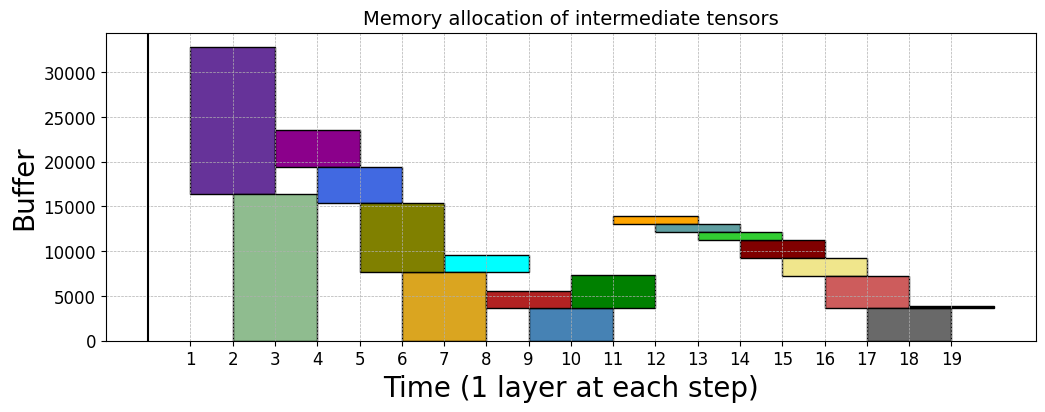

In [10]:
import matplotlib.pyplot as plt

# Define a list of colors for the bars
COLORS = ["maroon", "orange", "cyan", "cadetblue", "goldenrod", "rebeccapurple", "darkmagenta",
          "khaki", "darkseagreen", "steelblue", "firebrick", "green", "royalblue", "limegreen",
          "olive", "indianred", "dimgray", "black"]

# Create a new figure for the plot
plt.figure(figsize = (12,4))

# Iterate over the values in the 'sids' dictionary
for idx, sid in enumerate(sids.values()):
    # Plot a bar for each entry in 'sids'
    # x position is the midpoint of the interval [first, last]
    # width is the length of the interval plus 1 (to include the last time step)
    # bottom is the workspace offset
    # height is the size of the tensor
    # color is chosen from the COLORS list, cycling through if there are more bars than colors
    # edgecolor is set to black to color the borders of the bars
    plt.bar(x=sid["first"] + (sid["last"] + 1 - sid["first"]) / 2, width=(sid["last"] + 1 - sid["first"]),
            bottom=sid["workspace_offset"], height=sid["size"],
            color=COLORS[idx % len(COLORS)], edgecolor='black')

# Add a vertical line at x=0 for reference
plt.axvline(x=0, color='k', linewidth=1.5)

# Label the x and y axes
plt.xlabel("Time (1 layer at each step)")
plt.ylabel("Buffer")

# Set the title of the plot
plt.title("Memory allocation of intermediate tensors")

# Enable grid lines for both major and minor ticks
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set x-axis ticks to be at every integer within the range of the data
plt.xticks(range(int(min(sid["first"] for sid in sids.values())), 
                 int(max(sid["last"] for sid in sids.values())) + 1))

# Display the plot
plt.show()


<div class="alert alert-block alert-info">
<b>Question:</b> Look at the above graph. Analyze the memory allocation considering the algorithms you saw during lesson. Which algorithm seems to use?
</div>

# Step 3: Load and test the PULP SDK

For Deployment, we need two main components:  
1. **C Code** of the input deep neural network;
2. A working **Software Development Kit (SDK)**: the SDK is provided by the PULP group. For you, it is already pre-installed in the machine;

If you want to navigate the SDK, check it on the website: *https://github.com/pulp-platform/pulp-sdk*
Note that this is not the version you are using, since it is still restricted.

First of all, we want to load the correct SDK and try the board on a simple ***hello world*** application.
To do so, we need to execute the following steps:
1. add the PULP_SDK to the user’s OS environmental variables (we did it in the second cell of the notebook already);
2. navigate inside the folder;
3. source the correct board with the *sourceme.sh* file
4. Execute a simple example on the PULP online simulator, GVSoC;

Note that we first don't use the board, but the virtual simulator. To do it, you have to specify the argument *platform=gvsoc* inside the make all command

## GVSoC
Few worlds about the simulator. The PULP GVSOC is a versatile simulation framework tailored for PULP series of processors. It provides cycle-accurate modeling of PULP SoCs, enabling detailed performance analysis and verification. You can use GVSOC to efficiently debug, optimize, and validate software and hardware components before deployment. Its integration with development tools and open-source nature enhances the design and testing process in embedded systems.

In [11]:
!cd $PULP_SDK && source configs/pulp-open.sh && pwd && cd pmsis_tests/quick/hello && make clean all run platform=gvsoc

/home/alessio/pulp-sdk
RM  /home/alessio/pulp-sdk/pmsis_tests/quick/hello/BUILD/PULP/GCC_RISCV/
CC  test.c
CC  /home/alessio/pulp-sdk/rtos/pulpos/common/kernel/fll-v1.c
CC  /home/alessio/pulp-sdk/rtos/pulpos/common/kernel/freq-domains.c
CC  /home/alessio/pulp-sdk/rtos/pulpos/pulp/kernel/chips/pulp/soc.c
CC  /home/alessio/pulp-sdk/rtos/pmsis/pmsis_bsp/fs/read_fs/read_fs.c
CC  /home/alessio/pulp-sdk/rtos/pmsis/pmsis_bsp/fs/host_fs/semihost.c
CC  /home/alessio/pulp-sdk/rtos/pmsis/pmsis_bsp/fs/host_fs/host_fs.c
CC  /home/alessio/pulp-sdk/rtos/pmsis/pmsis_bsp/fs/fs.c
CC  /home/alessio/pulp-sdk/rtos/pmsis/pmsis_bsp/bsp/pulp.c
CC  /home/alessio/pulp-sdk/rtos/pulpos/common/lib/libc/minimal/io.c
CC  /home/alessio/pulp-sdk/rtos/pulpos/common/lib/libc/minimal/fprintf.c
CC  /home/alessio/pulp-sdk/rtos/pulpos/common/lib/libc/minimal/prf.c
CC  /home/alessio/pulp-sdk/rtos/pulpos/common/lib/libc/minimal/sprintf.c
CC  /home/alessio/pulp-sdk/rtos/pulpos/common/lib/libc/minimal/semihost.c
CC  /home/aless

# Step 4: Test the connection to the board and the network loading

## MATCH Network
Now let's first have a look at the files generated by MATCH:
1. in the *match_output/src/* folder there is the main.c file and all the support files needed for PULP.
2. in the *match_output/codegen/host/src/* folder there is all the code generated by MATCH: in *default_lib0.c* and *default_lib1.c* the full network is reported. From *default_lib2.c*, each file contains the code generated for each layer. 

<div class="alert alert-block alert-info">
<b>Question:</b> Which functions are called inside the layer? Which are the dimensions of the layer? Check in the onnx if they correspond.
</div>

<div class="alert alert-block alert-success">
<b>Code block:</b> Check the code of the <b>default_lib2.c</b> file, understand to which layer corresponds and reply to the questions.
</div>

In [12]:
!cat {MATCH_OUTPUT}/codegen/host/src/default_lib2.c

/*
 * Mohamed Amine Hamdi <mohamed.hamdi@polito.it>
 *
 * Copyright (C) 2024 Politecnico Di Torino
 * 
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License. 
*/

/*
expected latency -> 27337.0
expected energy -> 7348253.52
*/

/*
[{'name': 'K', 'index': 1, 'fullname': 'K_1', 'size': 31, 'mem_O': 'l1_mem', 'mem_W': 'l1_mem', 'mem_I': 'l1_mem'}]
*/

#include <match_dimensions.h>
#include <match_kernel.h>
#include <match_tile_indexes.h>
#include <match_mem.h>
#include <match_sync.h>
#include <matc

<div class="alert alert-block alert-success">
<b>Code block:</b> Check the code of the <b>default_lib0.c</b> and <b>default_lib1.c</b> file and understand the network execution in C. It is a bit more complicated than net.eval() &#128513.
</div>

Then, let's test our network on the data you previously collected in hands-on 3.
Despite the data having already been pre-processed and normalized, we still need to integerize them before feeding into the network (you saw in the previous hands-on that this step is automatically done in the MPS class in PLiNIO using an "Input Quantizer"):

$$X_{int} = \left\lfloor \frac{255}{\alpha} \cdot \min(X_{float}, \alpha) \right\rfloor $$

To perform the data integerization, we load all the data you saved in the previous hands-on.  
**Note that these data are patient-specific!! You can not take them from your colleagues**


In [31]:
datasets = icl.get_data()
dataloaders = icl.build_dataloaders(datasets, batch_size=1)
train_dl, val_dl, test_dl = dataloaders

image, label = next(iter(train_dl))
# Open and load the scaling value
with open(oenne_path+'checkpoints/03/rescaling_values.json', 'r') as file:
    scaling_values = json.load(file)

# Fill this value with the ones found in the hands-on 3
clip_value = scaling_values['clip_val']
scale_factor = (2**8 - 1) / (clip_value)
print(label)

Files already downloaded and verified
Files already downloaded and verified
tensor([9])


<div class="alert alert-block alert-info">
<b>Task:</b> Look at the function to integerize data and to the following graph. Are they identical to the floating point? Which is the theoretical error between the 2?
</div>


In [14]:
def integerize_data(data, clip_value, scale_factor):
    data = torch.clamp(torch.tensor(data), 0, clip_value)
    data = torch.floor(scale_factor * data)
    return data


After, we need to verify that the integerization of the input data works correctly.
Therefore, we plot the original and the integerized version of the data, before feeding to the GAP9 network.

## Data Format

Normally, in torch, networks receive the data in the CHW format, which means that 2 consecutive data belong to the same channel in successive spatial positions. On the other hand, GAP9 needs data to be ordered in the HWC format.  
**Check your data format!**

/tmp/ipykernel_45033/1704649548.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.clamp(torch.tensor(data), 0, clip_value)
2024-06-25 17:13:32,732 - _normalize_image_array +705 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0078125..0.0].


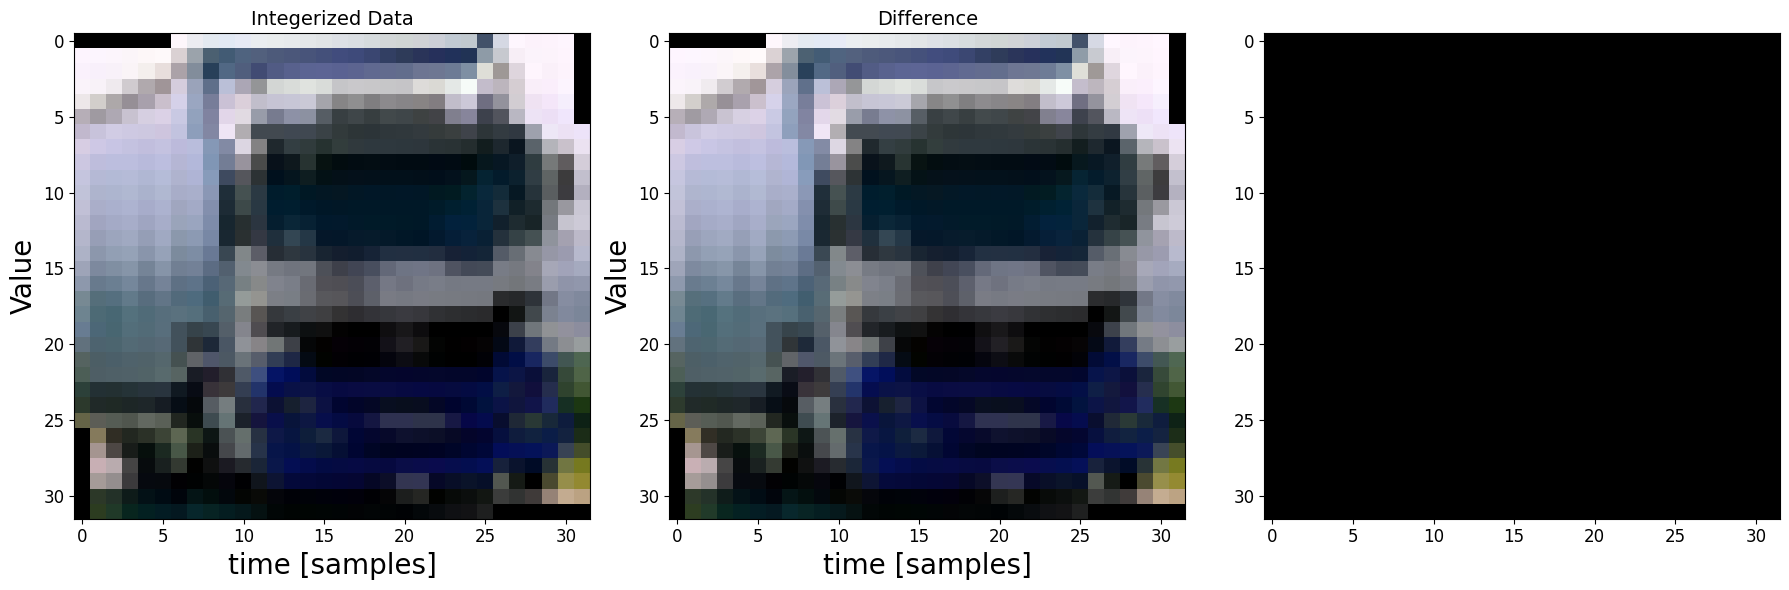

In [32]:
# Assume data, clip_value, scale_factor, and integerize_data are already defined

data_integer = integerize_data(image, clip_value, scale_factor)

# Create a figure and set of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot heatmap of data_integer in the first subplot
cax1 = ax1.imshow(data_integer.reshape(3,32,32).permute(1,2,0).numpy().astype(int),vmin=0, vmax=255, aspect='auto', cmap='viridis')
ax1.set_title('Integerized Data')
ax1.set_xlabel('time [samples]')
ax1.set_ylabel('Value')
ax1.grid(False)

# Plot heatmap of data[i] in the second subplot
cax2 = ax2.imshow(image.reshape(3,32,32).permute(1,2,0), aspect='auto', cmap='viridis')
ax2.set_title('Original Data')
ax2.set_xlabel('time [samples]')
ax2.set_ylabel('Value')
ax2.grid(False)

# Plot heatmap of data[i] in the second subplot
cax3 = ax3.imshow((data_integer/256-image).reshape(3,32,32).permute(1,2,0), aspect='auto', cmap='viridis')
ax2.set_title('Difference')
ax2.set_xlabel('time [samples]')
ax2.set_ylabel('Value')
ax2.grid(False)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Now, let's verify the deployment of the network on the board works.  
In order:
1. Load an input of your collected data, with the corresponding label; **Pay attention to the format**. The data type should be integer, HWC format and flattened.
2. Use the match_gap command **pulpatch.network_at** to deploy and execute the network on the board;
3. Compare the output with the golden label

**network_at** is a function from *pulpatch*. You can check it at *pulpatch/pulpatch/run.py*.
This function is used to build a network compiled to C code by MATCH, The function performs the following:
1. Copies libraries (back-end kernels that provide efficient computation -- pulp-nn, helpers for memory movement, etc..)
2. Create the *Makefile* and the *main.c* for the application. The main.c simply reads an input from a memory location and runs the layers created by match sequentially.
  
As parameters, you have to provide the network path, the input, the SDK path, and the *board* parameter.
True if you want to run on board, False if you want to run on gvsoc.

In [47]:
image, label = next(iter(train_dl))
input_data = integerize_data(image, clip_value, scale_factor).permute(0,2,3,1).flatten().numpy().astype(int)
#print(input_data)
#input_data = [70, 60, 49, 81, 72, 56, 85, 78, 62, 80, 73, 58, 77, 71, 58, 76, 70, 58, 72, 68, 57, 70, 65, 55, 66, 61, 51, 65, 60, 50, 62, 58, 48, 60, 54, 46, 60, 52, 46, 63, 56, 49, 69, 62, 55, 75, 68, 61, 89, 76, 72, 97, 81, 77, 96, 85, 78, 96, 87, 79, 92, 81, 75, 81, 67, 66, 66, 50, 52, 49, 36, 38, 41, 32, 32, 42, 36, 36, 48, 47, 43, 65, 65, 61, 92, 86, 86, 108, 99, 104, 113, 108, 111, 0, 0, 0, 91, 82, 73, 93, 87, 74, 94, 90, 76, 87, 83, 68, 84, 78, 63, 83, 77, 62, 80, 76, 61, 84, 81, 67, 92, 88, 74, 95, 91, 77, 96, 93, 79, 95, 89, 79, 94, 87, 79, 98, 91, 83, 99, 92, 84, 96, 89, 81, 100, 89, 87, 108, 95, 96, 107, 102, 94, 111, 106, 97, 118, 106, 106, 108, 102, 100, 89, 95, 86, 77, 79, 71, 61, 56, 50, 46, 35, 32, 33, 29, 15, 40, 48, 22, 48, 48, 33, 65, 59, 53, 79, 75, 69, 0, 0, 0, 72, 65, 59, 83, 80, 73, 96, 94, 85, 99, 96, 86, 94, 88, 77, 88, 82, 69, 84, 79, 67, 88, 84, 72, 88, 84, 72, 72, 68, 56, 78, 74, 62, 80, 74, 64, 79, 72, 62, 83, 76, 66, 88, 81, 71, 91, 84, 74, 94, 86, 79, 96, 94, 83, 101, 107, 84, 105, 110, 87, 120, 112, 103, 128, 119, 110, 110, 110, 90, 100, 99, 79, 97, 94, 74, 81, 75, 57, 90, 93, 58, 117, 133, 78, 88, 94, 60, 63, 60, 46, 85, 82, 72, 0, 0, 0, 31, 26, 21, 28, 28, 26, 56, 56, 54, 86, 83, 79, 95, 89, 82, 92, 85, 76, 91, 86, 76, 102, 98, 88, 105, 100, 90, 88, 83, 73, 90, 86, 77, 91, 86, 75, 83, 78, 66, 76, 71, 58, 73, 68, 54, 73, 68, 53, 74, 74, 52, 88, 98, 60, 109, 130, 78, 118, 137, 87, 131, 129, 96, 146, 113, 92, 150, 101, 82, 125, 92, 69, 95, 87, 56, 86, 93, 57, 102, 119, 66, 120, 141, 74, 92, 100, 62, 54, 51, 41, 108, 103, 103, 0, 0, 0, 22, 24, 20, 7, 10, 13, 11, 14, 17, 20, 20, 22, 40, 37, 37, 60, 57, 54, 70, 71, 66, 89, 88, 80, 111, 105, 96, 115, 109, 103, 112, 109, 106, 105, 107, 99, 98, 103, 86, 92, 101, 72, 87, 102, 59, 94, 112, 57, 118, 141, 78, 142, 169, 87, 131, 175, 85, 123, 165, 98, 163, 127, 83, 196, 88, 58, 199, 74, 62, 165, 73, 61, 82, 72, 39, 59, 86, 37, 78, 93, 39, 89, 95, 43, 75, 72, 43, 44, 36, 28, 90, 89, 85, 0, 0, 0, 12, 18, 16, 9, 14, 21, 9, 13, 21, 6, 8, 15, 8, 7, 12, 16, 15, 19, 21, 22, 25, 39, 37, 39, 66, 61, 61, 85, 84, 79, 91, 98, 87, 100, 117, 86, 112, 134, 87, 125, 153, 91, 135, 170, 90, 146, 184, 90, 153, 198, 106, 148, 190, 89, 140, 187, 88, 144, 178, 121, 189, 102, 74, 188, 59, 36, 147, 49, 40, 151, 54, 51, 84, 71, 43, 79, 111, 58, 101, 118, 60, 97, 108, 54, 86, 88, 53, 61, 59, 41, 78, 80, 66, 0, 0, 0, 9, 15, 15, 6, 10, 20, 8, 11, 23, 10, 12, 21, 11, 11, 18, 24, 22, 29, 27, 22, 29, 19, 14, 22, 15, 15, 19, 40, 52, 36, 100, 126, 81, 130, 166, 93, 145, 184, 98, 151, 192, 100, 154, 198, 98, 153, 199, 93, 143, 198, 97, 145, 193, 91, 167, 204, 111, 172, 184, 131, 192, 97, 76, 171, 54, 43, 119, 42, 43, 132, 44, 46, 95, 75, 45, 105, 141, 74, 115, 157, 74, 116, 156, 76, 116, 142, 83, 85, 97, 62, 68, 71, 53, 0, 0, 0, 8, 14, 16, 5, 9, 19, 7, 10, 21, 8, 9, 18, 10, 9, 17, 24, 22, 28, 42, 35, 34, 41, 40, 35, 27, 38, 25, 89, 118, 72, 149, 195, 110, 152, 203, 103, 149, 200, 98, 141, 193, 90, 144, 195, 92, 147, 199, 95, 146, 201, 96, 166, 212, 105, 177, 214, 114, 173, 194, 119, 159, 111, 68, 162, 63, 47, 143, 45, 47, 108, 40, 29, 103, 113, 57, 115, 171, 78, 118, 177, 74, 121, 180, 84, 131, 175, 99, 94, 117, 71, 65, 67, 48, 0, 0, 0, 9, 14, 18, 7, 11, 18, 8, 12, 17, 9, 11, 16, 9, 9, 13, 13, 11, 12, 47, 43, 33, 53, 60, 38, 77, 103, 61, 143, 188, 113, 144, 200, 102, 147, 203, 107, 146, 201, 109, 143, 197, 102, 146, 199, 102, 149, 200, 102, 151, 200, 99, 168, 208, 107, 180, 219, 119, 172, 213, 116, 152, 169, 92, 122, 99, 55, 109, 79, 47, 107, 122, 64, 114, 178, 88, 117, 185, 82, 126, 179, 81, 124, 179, 89, 125, 170, 95, 114, 139, 91, 73, 75, 57, 0, 0, 0, 6, 10, 15, 14, 19, 21, 17, 22, 21, 9, 12, 11, 11, 12, 10, 30, 30, 27, 50, 50, 44, 56, 71, 44, 131, 168, 107, 150, 201, 121, 145, 199, 121, 144, 199, 121, 144, 198, 116, 146, 199, 109, 149, 200, 101, 154, 204, 99, 152, 199, 105, 168, 207, 128, 177, 212, 129, 176, 217, 124, 163, 204, 119, 152, 188, 115, 146, 182, 109, 146, 192, 113, 131, 187, 105, 130, 182, 104, 136, 178, 104, 131, 169, 97, 124, 159, 95, 100, 121, 79, 58, 60, 47, 0, 0, 0, 20, 25, 16, 76, 89, 57, 72, 80, 61, 17, 17, 11, 38, 37, 28, 61, 60, 51, 39, 44, 35, 90, 113, 79, 154, 195, 125, 169, 216, 138, 164, 208, 150, 156, 200, 140, 155, 202, 127, 158, 206, 123, 164, 211, 124, 162, 205, 120, 125, 157, 95, 133, 154, 110, 139, 157, 105, 147, 167, 106, 149, 172, 120, 157, 183, 136, 163, 187, 136, 163, 181, 135, 153, 169, 128, 141, 162, 125, 117, 139, 105, 87, 104, 71, 69, 86, 58, 42, 55, 36, 36, 40, 34, 0, 0, 0, 57, 65, 36, 128, 148, 80, 89, 99, 63, 52, 49, 40, 69, 65, 54, 40, 39, 27, 51, 62, 37, 135, 161, 127, 146, 187, 138, 174, 217, 156, 173, 211, 159, 166, 209, 162, 150, 201, 149, 137, 188, 135, 151, 191, 146, 125, 149, 115, 94, 97, 80, 144, 137, 124, 146, 143, 118, 106, 105, 77, 73, 71, 53, 62, 62, 50, 63, 65, 53, 56, 57, 47, 46, 47, 37, 46, 47, 39, 30, 31, 27, 13, 16, 17, 11, 15, 20, 7, 11, 16, 26, 32, 31, 0, 0, 0, 89, 102, 59, 119, 139, 77, 75, 84, 53, 78, 75, 67, 52, 48, 38, 30, 28, 19, 102, 114, 84, 129, 156, 136, 122, 161, 157, 139, 186, 162, 144, 188, 149, 120, 175, 149, 97, 165, 155, 90, 154, 156, 96, 135, 146, 84, 87, 101, 104, 87, 98, 188, 169, 170, 215, 200, 188, 169, 157, 139, 92, 80, 69, 64, 54, 48, 45, 37, 32, 26, 20, 16, 33, 31, 28, 35, 37, 34, 12, 16, 14, 7, 13, 15, 9, 14, 19, 9, 13, 17, 30, 34, 33, 0, 0, 0, 118, 138, 81, 107, 127, 74, 54, 61, 39, 64, 61, 55, 33, 28, 22, 48, 45, 42, 116, 129, 116, 111, 140, 131, 133, 176, 167, 148, 199, 178, 141, 189, 171, 127, 170, 178, 103, 155, 183, 89, 147, 189, 92, 131, 178, 95, 100, 140, 108, 86, 112, 163, 132, 144, 179, 155, 152, 124, 105, 96, 93, 76, 72, 92, 77, 78, 71, 57, 60, 52, 43, 46, 36, 34, 36, 25, 28, 31, 10, 17, 19, 13, 21, 24, 15, 21, 27, 9, 13, 17, 36, 38, 36, 0, 0, 0, 121, 152, 84, 80, 99, 56, 22, 28, 14, 36, 32, 30, 34, 29, 26, 50, 46, 51, 92, 104, 118, 122, 154, 144, 141, 194, 141, 146, 202, 146, 144, 186, 175, 105, 124, 148, 67, 84, 121, 54, 84, 128, 73, 100, 141, 88, 99, 131, 93, 75, 97, 107, 74, 85, 96, 71, 69, 61, 42, 37, 49, 35, 36, 39, 28, 33, 42, 34, 37, 54, 49, 53, 16, 16, 20, 6, 10, 15, 8, 16, 21, 9, 18, 24, 15, 21, 29, 16, 19, 23, 34, 35, 31, 0, 0, 0, 124, 166, 90, 71, 92, 55, 52, 56, 48, 55, 51, 50, 57, 51, 48, 59, 55, 64, 90, 106, 122, 124, 163, 142, 132, 187, 108, 132, 185, 98, 123, 159, 118, 41, 52, 53, 44, 44, 54, 77, 75, 84, 84, 81, 86, 70, 66, 70, 59, 42, 47, 60, 33, 34, 53, 34, 26, 45, 34, 27, 31, 24, 29, 15, 13, 19, 18, 21, 19, 46, 49, 48, 25, 30, 31, 7, 12, 15, 6, 14, 19, 1, 13, 20, 5, 13, 22, 19, 22, 26, 37, 37, 32, 0, 0, 0, 134, 178, 103, 88, 105, 75, 54, 57, 51, 46, 43, 43, 40, 34, 35, 40, 37, 46, 69, 82, 93, 122, 154, 130, 134, 186, 104, 131, 185, 84, 123, 156, 91, 34, 45, 29, 86, 83, 77, 157, 139, 125, 164, 138, 124, 117, 93, 85, 73, 48, 44, 63, 41, 35, 60, 47, 39, 39, 35, 31, 15, 18, 25, 8, 16, 20, 6, 19, 15, 28, 41, 41, 36, 41, 43, 16, 15, 18, 13, 13, 15, 14, 11, 14, 29, 24, 31, 28, 28, 28, 40, 42, 32, 0, 0, 0, 146, 183, 121, 65, 74, 57, 27, 27, 25, 25, 21, 25, 20, 15, 21, 23, 21, 28, 20, 22, 35, 88, 105, 85, 138, 187, 103, 128, 185, 82, 110, 139, 79, 33, 35, 26, 62, 51, 50, 120, 96, 84, 120, 89, 78, 93, 61, 59, 76, 49, 47, 64, 44, 40, 39, 28, 26, 19, 18, 21, 9, 16, 23, 6, 16, 20, 4, 16, 18, 14, 22, 30, 37, 26, 30, 48, 23, 25, 62, 34, 32, 66, 34, 28, 68, 39, 46, 44, 35, 32, 45, 44, 33, 0, 0, 0, 103, 129, 92, 37, 40, 34, 22, 21, 25, 13, 12, 20, 12, 11, 18, 26, 25, 30, 12, 13, 17, 59, 74, 49, 141, 187, 102, 129, 185, 85, 105, 130, 76, 47, 38, 32, 42, 21, 23, 56, 31, 23, 62, 34, 27, 69, 43, 44, 55, 38, 40, 31, 24, 21, 23, 18, 18, 25, 22, 24, 12, 10, 15, 10, 8, 16, 15, 7, 16, 35, 12, 17, 70, 22, 18, 118, 50, 41, 133, 68, 53, 113, 68, 59, 62, 30, 39, 42, 26, 29, 57, 44, 42, 0, 0, 0, 66, 75, 56, 16, 13, 9, 30, 29, 31, 30, 33, 39, 11, 13, 16, 26, 27, 22, 42, 42, 35, 79, 92, 60, 142, 184, 101, 127, 179, 84, 94, 115, 66, 41, 36, 34, 27, 19, 25, 26, 19, 18, 29, 23, 23, 25, 21, 26, 20, 20, 24, 36, 38, 38, 43, 40, 42, 36, 28, 31, 38, 26, 29, 35, 22, 28, 61, 31, 32, 107, 49, 32, 146, 66, 41, 189, 90, 59, 174, 80, 47, 96, 50, 36, 23, 7, 13, 37, 30, 35, 53, 42, 45, 0, 0, 0, 117, 105, 85, 63, 38, 21, 59, 41, 29, 43, 33, 30, 27, 18, 13, 52, 40, 26, 49, 42, 32, 68, 76, 50, 144, 181, 106, 127, 174, 86, 78, 95, 49, 31, 33, 33, 12, 19, 28, 8, 15, 19, 4, 9, 11, 7, 9, 12, 15, 15, 19, 24, 22, 26, 31, 24, 27, 50, 38, 41, 53, 36, 39, 50, 34, 37, 104, 65, 50, 178, 104, 65, 183, 98, 60, 179, 88, 51, 190, 94, 52, 101, 49, 29, 9, 5, 5, 29, 34, 36, 33, 32, 33, 0, 0, 0, 172, 139, 99, 190, 124, 84, 120, 59, 32, 77, 26, 15, 124, 71, 58, 138, 85, 67, 38, 16, 12, 49, 54, 38, 150, 182, 117, 132, 174, 94, 74, 85, 44, 32, 23, 21, 26, 18, 24, 23, 12, 11, 38, 16, 12, 52, 16, 12, 45, 16, 17, 31, 14, 20, 34, 16, 23, 45, 28, 33, 35, 19, 25, 28, 15, 21, 97, 58, 41, 200, 129, 86, 139, 78, 51, 79, 27, 17, 165, 80, 53, 138, 67, 43, 18, 14, 8, 29, 32, 33, 26, 22, 23, 0, 0, 0, 189, 139, 86, 218, 119, 71, 205, 110, 70, 133, 48, 30, 145, 70, 61, 154, 78, 67, 54, 24, 25, 36, 39, 31, 149, 174, 121, 141, 183, 102, 77, 98, 42, 63, 48, 28, 80, 44, 35, 98, 44, 36, 121, 56, 46, 150, 73, 54, 109, 58, 48, 55, 28, 32, 62, 37, 42, 41, 21, 27, 37, 22, 28, 24, 15, 24, 88, 53, 44, 193, 121, 89, 113, 57, 45, 41, 11, 19, 101, 38, 31, 174, 85, 62, 70, 40, 32, 31, 26, 27, 24, 15, 17, 0, 0, 0, 182, 122, 72, 186, 91, 53, 217, 119, 70, 172, 77, 47, 87, 37, 32, 72, 33, 34, 42, 27, 30, 23, 20, 23, 118, 127, 93, 159, 195, 112, 131, 167, 85, 155, 164, 107, 145, 113, 70, 155, 68, 49, 144, 56, 46, 145, 59, 40, 107, 56, 34, 75, 39, 31, 75, 40, 39, 56, 28, 32, 42, 20, 23, 33, 20, 25, 65, 34, 31, 156, 87, 66, 134, 64, 47, 59, 25, 30, 48, 21, 23, 154, 73, 56, 117, 51, 42, 31, 29, 25, 19, 18, 22, 0, 0, 0, 183, 118, 70, 135, 66, 38, 167, 73, 43, 212, 103, 71, 131, 62, 46, 31, 19, 19, 17, 19, 24, 31, 17, 25, 70, 60, 45, 143, 153, 97, 180, 189, 130, 211, 218, 157, 184, 169, 101, 148, 74, 32, 157, 67, 44, 175, 76, 54, 163, 81, 55, 129, 53, 38, 95, 29, 26, 85, 32, 37, 64, 23, 29, 58, 28, 33, 59, 26, 26, 85, 37, 27, 83, 38, 27, 54, 37, 38, 33, 27, 28, 118, 61, 51, 117, 51, 47, 36, 26, 27, 22, 21, 28, 0, 0, 0, 160, 89, 50, 106, 50, 38, 142, 62, 55, 178, 85, 55, 160, 73, 44, 31, 19, 19, 6, 18, 25, 43, 27, 34, 66, 47, 41, 79, 67, 44, 94, 74, 57, 134, 121, 81, 186, 176, 105, 144, 100, 39, 132, 59, 26, 160, 73, 51, 192, 95, 70, 186, 80, 61, 124, 39, 31, 94, 30, 32, 84, 33, 38, 81, 32, 38, 75, 28, 34, 49, 16, 20, 38, 22, 25, 35, 34, 36, 15, 16, 18, 54, 25, 25, 72, 26, 29, 45, 24, 35, 18, 16, 26, 0, 0, 0, 156, 82, 51, 112, 47, 44, 122, 60, 59, 116, 63, 36, 137, 72, 43, 41, 18, 21, 6, 15, 22, 29, 21, 19, 44, 27, 22, 41, 27, 23, 66, 44, 42, 95, 60, 42, 176, 150, 98, 171, 142, 79, 112, 58, 26, 85, 42, 27, 106, 41, 26, 162, 76, 58, 123, 58, 47, 89, 41, 38, 85, 43, 42, 89, 36, 40, 87, 31, 42, 57, 29, 41, 27, 22, 32, 17, 15, 22, 17, 13, 21, 19, 13, 19, 44, 24, 26, 42, 22, 36, 10, 11, 23, 0, 0, 0, 128, 64, 45, 114, 57, 52, 117, 62, 51, 104, 58, 41, 84, 48, 38, 37, 14, 18, 26, 18, 24, 52, 36, 30, 67, 46, 39, 48, 35, 38, 48, 31, 31, 92, 45, 38, 145, 99, 62, 212, 176, 115, 153, 90, 62, 79, 54, 45, 77, 46, 41, 98, 51, 45, 71, 38, 34, 67, 38, 34, 79, 44, 40, 81, 35, 37, 72, 30, 39, 35, 21, 27, 10, 13, 17, 10, 11, 19, 24, 13, 30, 12, 14, 21, 12, 19, 12, 18, 12, 20, 4, 14, 25, 0, 0, 0, 103, 55, 44, 112, 75, 62, 128, 73, 51, 130, 62, 61, 50, 29, 38, 39, 29, 29, 71, 44, 50, 92, 57, 50, 106, 72, 62, 73, 53, 57, 34, 18, 14, 92, 42, 33, 124, 65, 32, 192, 134, 77, 186, 94, 67, 89, 48, 43, 72, 54, 59, 56, 39, 47, 26, 15, 21, 41, 25, 27, 68, 35, 33, 68, 34, 36, 41, 26, 30, 14, 16, 12, 6, 17, 12, 10, 16, 21, 23, 13, 32, 12, 16, 21, 0, 17, 4, 5, 12, 15, 3, 17, 28, 0, 0, 0, 96, 58, 47, 117, 76, 66, 122, 69, 55, 125, 68, 61, 63, 39, 38, 33, 26, 26, 73, 45, 45, 113, 64, 54, 122, 75, 63, 84, 57, 54, 43, 26, 20, 111, 65, 53, 118, 59, 37, 163, 95, 61, 182, 97, 70, 86, 41, 34, 45, 33, 36, 28, 23, 29, 15, 12, 21, 23, 18, 27, 39, 25, 31, 41, 28, 33, 18, 17, 20, 10, 11, 11, 19, 21, 20, 17, 15, 18, 13, 9, 16, 8, 13, 16, 5, 12, 11, 13, 14, 18, 7, 11, 17, 0, 0, 0, 83, 41, 34, 95, 50, 44, 111, 61, 52, 114, 66, 55, 78, 51, 44, 30, 23, 23, 45, 25, 24, 103, 61, 50, 119, 76, 66, 65, 40, 38, 47, 29, 25, 110, 72, 62, 95, 54, 46, 87, 46, 35, 93, 46, 34, 66, 38, 36, 33, 26, 29, 13, 12, 16, 12, 12, 21, 16, 15, 25, 20, 13, 20, 20, 12, 16, 20, 15, 16, 22, 16, 17, 31, 24, 24, 38, 30, 31, 33, 27, 27, 24, 18, 21, 28, 17, 22, 37, 24, 29, 37, 28, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#dataset[0][0][0]
network_res=pulpatch.network_at(match_res=res,network_path=str(pathlib.Path(f'{MATCH_OUTPUT}')),
                                 inputs=[{"name":res.match_inputs[idx]["name"],
                                          "size":res.match_inputs[idx]["size"],
                                          "values":input_data}
                                          for idx in range(len(res.match_inputs))],
                                 board = False,
                                 sdk_path=os.environ.get("PULP_SDK"),
                                target_name="PULP-OPEN")
print(network_res)
print(np.argmax(network_res["output"]))
print(label)

/tmp/ipykernel_45033/1704649548.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.clamp(torch.tensor(data), 0, clip_value)


Building ...
{'kernel_cycles': [0], 'cycles': 2198083, 'num_errors': 0, 'correct': True, 'output': [47163, 10175, -9658, -25310, -3728, -30720, -25070, -1536, 22268, 12944]}
0
tensor([0])
